In [13]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
import os
import glob
import math

In [81]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def yolo2bbox(bboxes, w, h):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    ## Desnormalizar coordenadas
    xmin = int(xmin*w)
    ymin = int(ymin*h)
    xmax = int(xmax*w)
    ymax = int(ymax*h)
    return xmin, ymin, xmax, ymax

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    h, w, _ = img.shape
    x_min, y_min , x_max, y_max = yolo2bbox(bbox, w, h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(img)
    
def read_labels(label_path, image_name):
    with open(os.path.join(label_path, image_name+'.txt'), 'r') as f:
        bboxes = []
        labels = []
        label_lines = f.readlines()
        for label_line in label_lines:
            label, x_c, y_c, w, h= label_line.split(' ')
            x_c = min(float(x_c),1.0) 
            y_c = min(float(y_c),1.0) 
            w = min(round(float(w),4),1.0)
            print("w:",w)
            h = min(round(float(h),4),1.0)
            print("h:",h)
            bboxes.append([x_c, y_c, w, h])
            labels.append(label)
    return bboxes, labels

In [82]:
# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {
    "0": "rice leaf roller",
    "1": "rice leaf caterpillar",
    "2": "paddy stem maggot",
    "3": "asiatic rice borer",
    "4": "yellow rice borer",
    "5": "rice gall midge",
    "6": "Rice Stemfly",
    "7": "brown plant hopper",
    "8": "white backed plant hopper",
    "9": "small brown plant hopper",
    "10": "rice water weevil",
    "11": "rice leafhopper",
    "12": "grain spreader thrips",
    "13": "rice shell pest",
    "14": "grub",
    "15": "mole cricket",
    "16": "wireworm",
    "17": "white margined moth",
    "18": "black cutworm",
    "19": "large cutworm",
    "20": "yellow cutworm",
    "21": "red spider",
    "22": "corn borer",
    "23": "army worm",
    "24": "aphids",
    "25": "Potosiabre vitarsis",
    "26": "peach borer",
    "27": "english grain aphid",
    "28": "green bug",
    "29": "bird cherry-oataphid",
    "30": "wheat blossom midge",
    "31": "penthaleus major",
    "32": "longlegged spider mite",
    "33": "wheat phloeothrips",
    "34": "wheat sawfly",
    "35": "cerodonta denticornis",
    "36": "beet fly",
    "37": "flea beetle",
    "38": "cabbage army worm",
    "39": "beet army worm",
    "40": "Beet spot flies",
    "41": "meadow moth",
    "42": "beet weevil",
    "43": "sericaorient alismots chulsky",
    "44": "alfalfa weevil",
    "45": "flax budworm",
    "46": "alfalfa plant bug",
    "47": "tarnished plant bug",
    "48": "Locustoidea",
    "49": "lytta polita",
    "50": "legume blister beetle",
    "51": "blister beetle",
    "52": "therioaphis maculata Buckton",
    "53": "odontothrips loti",
    "54": "Thrips",
    "55": "alfalfa seed chalcid",
    "56": "Pieris canidia",
    "57": "Apolygus lucorum",
    "58": "Limacodidae",
    "59": "Viteus vitifoliae",
    "60": "Colomerus vitis",
    "61": "Brevipoalpus lewisi McGregor",
    "62": "oides decempunctata",
    "63": "Polyphagotars onemus latus",
    "64": "Pseudococcus comstocki Kuwana",
    "65": "parathrene regalis",
    "66": "Ampelophaga",
    "67": "Lycorma delicatula",
    "68": "Xylotrechus",
    "69": "Cicadella viridis",
    "70": "Miridae",
    "71": "Trialeurodes vaporariorum",
    "72": "Erythroneura apicalis",
    "73": "Papilio xuthus",
    "74": "Panonchus citri McGregor",
    "75": "Phyllocoptes oleiverus ashmead",
    "76": "Icerya purchasi Maskell",
    "77": "Unaspis yanonensis",
    "78": "Ceroplastes rubens",
    "79": "Chrysomphalus aonidum",
    "80": "Parlatoria zizyphus Lucus",
    "81": "Nipaecoccus vastalor",
    "82": "Aleurocanthus spiniferus",
    "83": "Tetradacus c Bactrocera minax",
    "84": "Dacus dorsalis(Hendel)",
    "85": "Bactrocera tsuneonis",
    "86": "Prodenia litura",
    "87": "Adristyrannus",
    "88": "Phyllocnistis citrella Stainton",
    "89": "Toxoptera citricidus",
    "90": "Toxoptera aurantii",
    "91": "Aphis citricola Vander Goot",
    "92": "Scirtothrips dorsalis Hood",
    "93": "Dasineura sp",
    "94": "Lawana imitata Melichar",
    "95": "Salurnis marginella Guerr",
    "96": "Deporaus marginatus Pascoe",
    "97": "Chlumetia transversa",
    "98": "Mango flat beak leafhopper",
    "99": "Rhytidodera bowrinii white",
    "100": "Sternochetus frigidus",
    "101": "Cicadellidae"
  }

In [83]:
data_path = "VOC2007/data/train"
images_path = f"{data_path}/images"
all_images = []
all_images.extend(glob.glob(images_path+'/*.jpg'))
all_images.extend(glob.glob(images_path+'/*.JPG'))

w: 0.8644
h: 0.7511


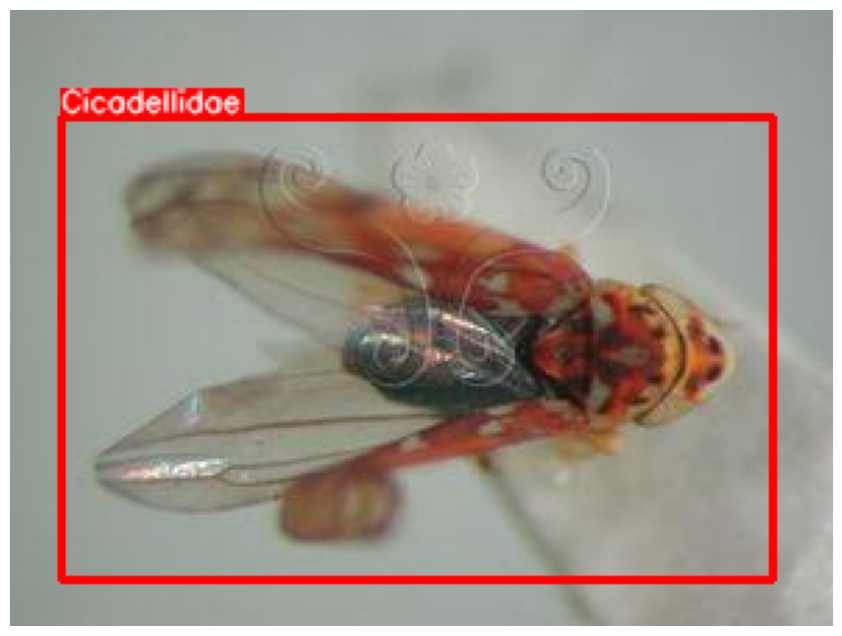

In [84]:

image_path = "VOC2007/data/train/images/IP102005711.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_name = '.'.join(image_path.split(os.path.sep)[-1].split('.')[:-1])
bboxes, labels = read_labels("VOC2007/data/train/labels", image_name)


visualize(image, bboxes, labels, category_id_to_name)

In [77]:
def save_transformed(transformed, output_path, image_name, image_id, prefix = "aug"):
    image = transformed['image']
    bboxes = transformed['bboxes']
    labels = transformed['category_ids']
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    path_new_image = f"{output_path}/images/{prefix}_{image_id:06d}_{image_name}.jpg"
    output_path_label = f"{output_path}/labels/{prefix}_{image_id:06d}_{image_name}.txt"
    cv2.imwrite(path_new_image, image)
    save_labels(output_path_label, bboxes, labels)

def save_labels(output_path_label, bboxes, category_ids):
    bbox_coordinates = []
    for bbox, id in zip(bboxes, category_ids):
        xc, yc, wo, ho = bbox
        line = str(id) + " " + str(xc) + " " + str(yc) + " " + str(wo) + " " + str(ho)
        bbox_coordinates.append(line)
    
    with open(output_path_label, 'w') as f:
        f.write("\n".join(bbox_coordinates))

In [87]:
from tqdm.auto import tqdm

transform = A.Compose(
    [A.HorizontalFlip(p=0.5)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

def augmentation_images(data_path, transform):
    images_path = f"{data_path}/images"
    all_images = []
    all_images.extend(glob.glob(images_path+'/*.jpg'))
    all_images.extend(glob.glob(images_path+'/*.JPG'))
    output_path = f"{os.path.dirname(data_path)}/aug"
    print("output_path:", output_path)
    os.makedirs(f"{output_path}/images", exist_ok= True)
    os.makedirs(f"{output_path}/labels", exist_ok= True)
    for id_img ,image_path in tqdm(enumerate(all_images)):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_name = '.'.join(image_path.split(os.path.sep)[-1].split('.')[:-1])
        labels_path = f"{os.path.dirname(images_path)}/labels"
        bboxes, labels = read_labels(labels_path, image_name)
        print("bboxes:", bboxes)
        transformed = transform(image=image, bboxes=bboxes, category_ids=labels)
        save_transformed(transformed, output_path, image_name, image_id = id_img, prefix = "AUG")


data_path = "VOC2007/data/train"

augmentation_images(data_path, transform)

output_path: VOC2007/data/aug


6it [00:00, 58.21it/s]

w: 0.82
h: 0.8785
bboxes: [[0.498, 0.4807, 0.82, 0.8785]]
w: 0.938
h: 0.786
bboxes: [[0.496, 0.5677, 0.938, 0.786]]
w: 0.8696
h: 0.4174
bboxes: [[0.5251, 0.7913, 0.8696, 0.4174]]
w: 0.7375
h: 0.6578
bboxes: [[0.5175, 0.56, 0.7375, 0.6578]]
w: 0.6845
h: 0.2237
bboxes: [[0.463, 0.7103, 0.6845, 0.2237]]
w: 0.4824
h: 0.3651
bboxes: [[0.4774, 0.39, 0.4824, 0.3651]]
w: 0.7833
h: 0.835
bboxes: [[0.4883, 0.5075, 0.7833, 0.835]]
w: 0.415
h: 0.7697
bboxes: [[0.4925, 0.4991, 0.415, 0.7697]]
w: 0.5107
h: 0.594
bboxes: [[0.4318, 0.527, 0.5107, 0.594]]
w: 0.8417
h: 0.8246
bboxes: [[0.4942, 0.5545, 0.8417, 0.8246]]
w: 0.8771
h: 0.7829
bboxes: [[0.4843, 0.6085, 0.8771, 0.7829]]
w: 0.8272
h: 0.9842
bboxes: [[0.4465, 0.5079, 0.8272, 0.9842]]
w: 0.4238
h: 0.6667
bboxes: [[0.5419, 0.515, 0.4238, 0.6667]]
w: 0.528
h: 0.6568
bboxes: [[0.508, 0.4794, 0.528, 0.6568]]


14it [00:00, 58.43it/s]

w: 0.5125
h: 0.4564
bboxes: [[0.5844, 0.481, 0.5125, 0.4564]]
w: 0.482
h: 0.7354
bboxes: [[0.519, 0.4955, 0.482, 0.7354]]
w: 0.55
h: 0.7525
bboxes: [[0.4175, 0.4763, 0.55, 0.7525]]
w: 0.5127
h: 0.5495
bboxes: [[0.5742, 0.4596, 0.5127, 0.5495]]


32it [00:00, 55.90it/s]

w: 0.5267
h: 0.6682
bboxes: [[0.6, 0.3618, 0.5267, 0.6682]]
w: 0.5925
h: 0.6213
bboxes: [[0.3762, 0.4618, 0.5925, 0.6213]]
w: 0.6978
h: 0.632
bboxes: [[0.5489, 0.53, 0.6978, 0.632]]
w: 0.3368
h: 0.7205
w: 0.4211
h: 0.7336
bboxes: [[0.2912, 0.3865, 0.3368, 0.7205], [0.7509, 0.3712, 0.4211, 0.7336]]
w: 0.4814
h: 0.6923
bboxes: [[0.4746, 0.4593, 0.4814, 0.6923]]
w: 0.4239
h: 0.4742
bboxes: [[0.654, 0.3918, 0.4239, 0.4742]]
w: 0.3578
h: 0.6174
bboxes: [[0.3322, 0.6007, 0.3578, 0.6174]]
w: 0.3812
h: 0.5866
bboxes: [[0.5031, 0.4683, 0.3812, 0.5866]]
w: 0.564
h: 0.3275
bboxes: [[0.468, 0.4415, 0.564, 0.3275]]
w: 0.8956
h: 0.7333
bboxes: [[0.4896, 0.5233, 0.8956, 0.7333]]
w: 0.7
h: 0.4985
bboxes: [[0.432, 0.4414, 0.7, 0.4985]]
w: 0.1491
h: 0.1389
w: 0.1236
h: 0.1222
w: 0.1673
h: 0.1333
w: 0.1491
h: 0.1056
w: 0.1091
h: 0.1111
w: 0.1927
h: 0.1333
w: 0.5055
h: 0.2833
w: 0.1709
h: 0.1222
bboxes: [[0.1327, 0.7139, 0.1491, 0.1389], [0.2582, 0.65, 0.1236, 0.1222], [0.3709, 0.7111, 0.1673, 0.1333], [0

50it [00:00, 71.16it/s]

w: 0.615
h: 0.5605
bboxes: [[0.5525, 0.6369, 0.615, 0.5605]]
w: 0.995
h: 0.775
bboxes: [[0.5025, 0.5325, 0.995, 0.775]]
w: 0.7163
h: 0.9325
bboxes: [[0.4969, 0.5019, 0.7163, 0.9325]]
w: 0.7754
h: 0.5522
bboxes: [[0.5662, 0.5896, 0.7754, 0.5522]]
w: 0.8944
h: 0.6167
bboxes: [[0.4875, 0.4528, 0.8944, 0.6167]]
w: 0.7073
h: 0.5132
bboxes: [[0.4645, 0.4912, 0.7073, 0.5132]]
w: 0.821
h: 0.5674
bboxes: [[0.5282, 0.5306, 0.821, 0.5674]]
w: 0.5354
h: 0.7397
bboxes: [[0.4832, 0.4612, 0.5354, 0.7397]]
w: 0.712
h: 0.4866
bboxes: [[0.574, 0.5121, 0.712, 0.4866]]
w: 0.682
h: 0.9321
bboxes: [[0.4793, 0.4977, 0.682, 0.9321]]
w: 0.3937
h: 0.7
bboxes: [[0.4781, 0.5944, 0.3937, 0.7]]
w: 0.6194
h: 0.4891
bboxes: [[0.5377, 0.5182, 0.6194, 0.4891]]
w: 0.752
h: 0.5836
bboxes: [[0.4932, 0.4899, 0.752, 0.5836]]
w: 0.5455
h: 0.461
bboxes: [[0.4628, 0.6059, 0.5455, 0.461]]
w: 0.7712
h: 0.97
bboxes: [[0.4894, 0.4863, 0.7712, 0.97]]
w: 0.5755
h: 0.4893
bboxes: [[0.5551, 0.4251, 0.5755, 0.4893]]
w: 0.6541
h: 0.728


67it [00:01, 71.81it/s]

w: 0.9464
h: 0.8333
bboxes: [[0.4964, 0.546, 0.9464, 0.8333]]
w: 0.722
h: 0.6997
bboxes: [[0.575, 0.524, 0.722, 0.6997]]
w: 0.2715
h: 0.4028
w: 0.3444
h: 0.375
bboxes: [[0.3609, 0.5579, 0.2715, 0.4028], [0.5894, 0.5486, 0.3444, 0.375]]
w: 0.3597
h: 0.7556
bboxes: [[0.5618, 0.5926, 0.3597, 0.7556]]
w: 0.2662
h: 0.6161
bboxes: [[0.5044, 0.4597, 0.2662, 0.6161]]
w: 0.3663
h: 0.6791
bboxes: [[0.4406, 0.4479, 0.3663, 0.6791]]
w: 0.5758
h: 0.8434
bboxes: [[0.4913, 0.5, 0.5758, 0.8434]]
w: 0.5
h: 0.4281
bboxes: [[0.4663, 0.5016, 0.5, 0.4281]]
w: 0.9375
h: 0.8151
bboxes: [[0.5047, 0.4922, 0.9375, 0.8151]]
w: 0.9714
h: 0.8881
bboxes: [[0.5042, 0.4883, 0.9714, 0.8881]]
w: 0.7887
h: 0.2911
bboxes: [[0.4894, 0.5211, 0.7887, 0.2911]]
w: 0.4515
h: 0.65
bboxes: [[0.2742, 0.5841, 0.4515, 0.65]]
w: 0.586
h: 0.6445
bboxes: [[0.445, 0.5038, 0.586, 0.6445]]
w: 0.6592
h: 0.7392
bboxes: [[0.4164, 0.4991, 0.6592, 0.7392]]
w: 0.1496
h: 0.48
w: 0.5924
h: 0.8267
bboxes: [[0.1129, 0.2978, 0.1496, 0.48], [0.5543,

83it [00:01, 65.80it/s]

w: 0.823
h: 0.7159
bboxes: [[0.5194, 0.4764, 0.823, 0.7159]]
w: 0.444
h: 0.5622
bboxes: [[0.4646, 0.505, 0.444, 0.5622]]
w: 0.846
h: 0.8846
bboxes: [[0.509, 0.5192, 0.846, 0.8846]]
w: 0.9295
h: 0.6283
bboxes: [[0.5192, 0.4071, 0.9295, 0.6283]]
w: 0.5922
h: 0.691
bboxes: [[0.6206, 0.4186, 0.5922, 0.691]]
w: 0.6839
h: 0.4417
bboxes: [[0.4065, 0.5218, 0.6839, 0.4417]]
w: 0.8428
h: 0.726
bboxes: [[0.5094, 0.627, 0.8428, 0.726]]
w: 0.454
h: 0.497
bboxes: [[0.449, 0.5444, 0.454, 0.497]]
w: 0.626
h: 0.8257
bboxes: [[0.467, 0.4186, 0.626, 0.8257]]
w: 0.5387
h: 0.9685
bboxes: [[0.4806, 0.4991, 0.5387, 0.9685]]
w: 0.8689
h: 0.8981
bboxes: [[0.4641, 0.4866, 0.8689, 0.8981]]
w: 0.5945
h: 0.7713
bboxes: [[0.4464, 0.6144, 0.5945, 0.7713]]


ValueError: Expected y_max for bbox (0.14915, 0.22874999999999995, 0.74365, 1.0000499999999999, '19') to be in the range [0.0, 1.0], got 1.0000499999999999.

In [88]:
transform = A.Compose(
    [A.HorizontalFlip(p=0.2)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

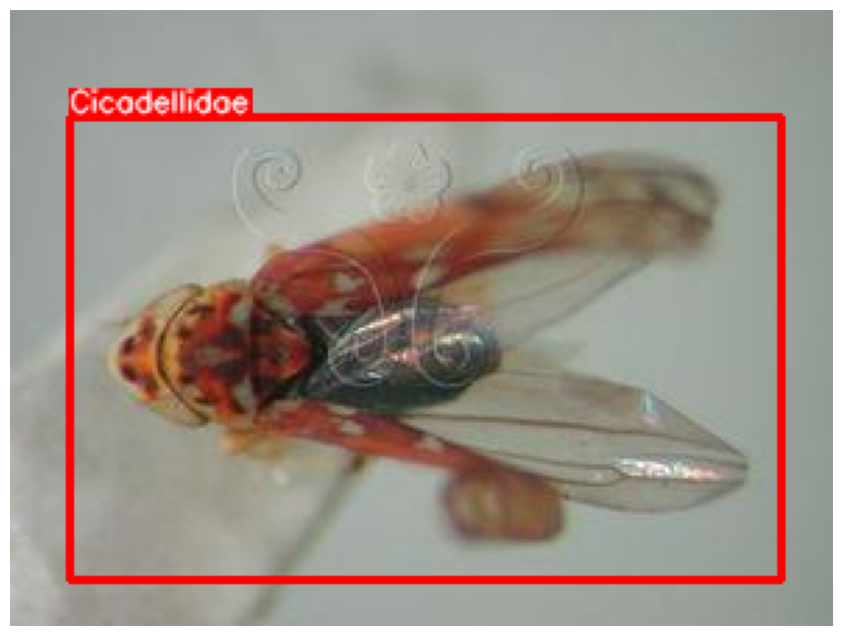

In [89]:
random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=labels)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)